In [100]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer



In [1]:
!wget 'https://drive.google.com/uc?id=1VJq6qDgMQx-sM4LuBjimM4K4tQoXiplv' -O car_data.csv

--2023-10-26 13:02:04--  https://drive.google.com/uc?id=1VJq6qDgMQx-sM4LuBjimM4K4tQoXiplv
Resolving drive.google.com (drive.google.com)... 173.194.192.113, 173.194.192.100, 173.194.192.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.192.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jjo3ifvfg8odjfq15b0ra0a1gvpt1jt8/1698325275000/02611596255248067438/*/1VJq6qDgMQx-sM4LuBjimM4K4tQoXiplv?uuid=3edb11fa-8a93-4b37-8a6a-16d3179d6271 [following]
--2023-10-26 13:02:04--  https://doc-0c-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jjo3ifvfg8odjfq15b0ra0a1gvpt1jt8/1698325275000/02611596255248067438/*/1VJq6qDgMQx-sM4LuBjimM4K4tQoXiplv?uuid=3edb11fa-8a93-4b37-8a6a-16d3179d6271
Resolving doc-0c-84-docs.googleusercontent.com (doc-0c-84-docs.googleusercontent.com)... 74.125.70.132, 2607:f8b0:4001:c02::84
Connecting to doc

In [2]:
DATASET_PATH = 'car_data.csv'
PREPARED_DATASET_PATH_TRAIN = 'data_train.csv'
PREPARED_DATASET_PATH_TEST = 'data_test.csv'


SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

In [5]:
df = pd.read_csv(DATASET_PATH, sep=',')

In [19]:
df.head(10)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
5,vitara brezza,2018,9.25,9.83,2071,Diesel,Dealer,Manual,0
6,ciaz,2015,6.75,8.12,18796,Petrol,Dealer,Manual,0
7,s cross,2015,6.50,8.61,33429,Diesel,Dealer,Manual,0
8,ciaz,2016,8.75,8.89,20273,Diesel,Dealer,Manual,0
9,ciaz,2015,7.45,8.92,42367,Diesel,Dealer,Manual,0


Проверяем типы данных и пропуски:

In [12]:
df.dtypes, df.isna().sum()

(Car_Name          object
 Year               int64
 Selling_Price    float64
 Present_Price    float64
 Kms_Driven         int64
 Fuel_Type         object
 Seller_Type       object
 Transmission      object
 Owner              int64
 dtype: object,
 Car_Name         0
 Year             0
 Selling_Price    0
 Present_Price    0
 Kms_Driven       0
 Fuel_Type        0
 Seller_Type      0
 Transmission     0
 Owner            0
 dtype: int64)

Посмотрим основные метрики по таблице:

In [18]:
df.describe().round(2)

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.00,301.00,301.00,301.00,301.00
mean,2013.63,4.66,7.63,36947.21,0.04
std,2.89,5.08,8.64,38886.88,0.25
min,2003.00,0.10,0.32,500.00,0.00
25%,2012.00,0.90,1.20,15000.00,0.00
50%,2014.00,3.60,6.40,32000.00,0.00
75%,2016.00,6.00,9.90,48767.00,0.00
max,2018.00,35.00,92.60,500000.00,3.00


Проанализировал признаки в которых сомневался:
1) Количество владельцев

Почти у всех машин этот признак = 0, только у 11 машин из 301 он ненулевой. Исключим этот признак при обучении модели.

2) Распределение по годам

Объединим авто 2003-2007г и 2017-2018г

3) Тип топлива

CNG - всего 2шт. Исключим их из выборки для обучения


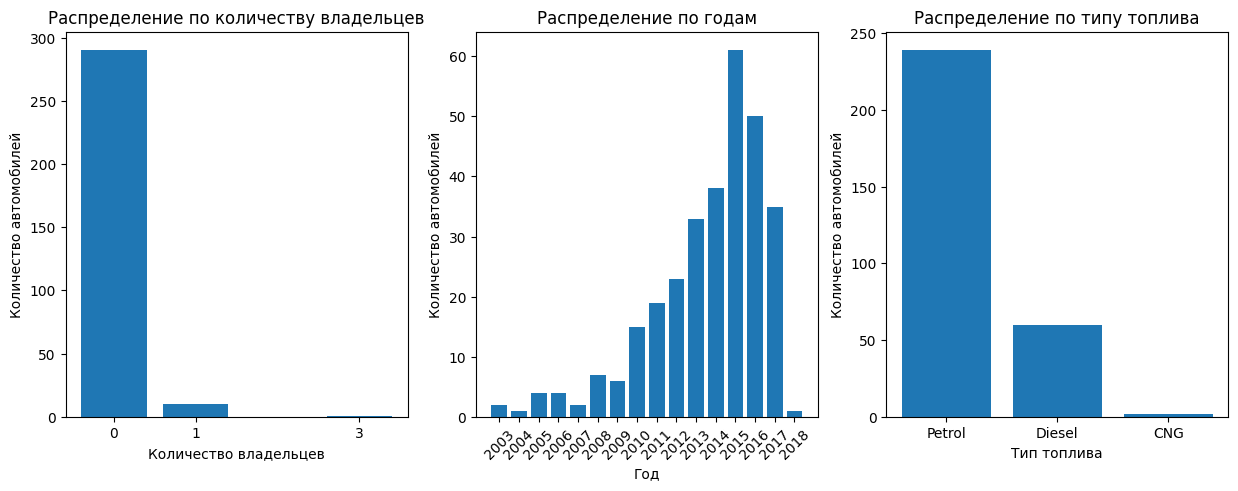

In [70]:
# Получаем данные
owners_count = df['Owner'].value_counts()
year_count = df['Year'].value_counts()
fuel_count = df['Fuel_Type'].value_counts()

# Создаем окно для графиков
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# График для owners_count
axs[0].bar(owners_count.index, owners_count.values)
axs[0].set_title('Распределение по количеству владельцев')
axs[0].set_xlabel('Количество владельцев')
axs[0].set_ylabel('Количество автомобилей')
axs[0].set_xticks(owners_count.index)
axs[0].set_xticklabels(owners_count.index, rotation=0)


# График для year_count
axs[1].bar(year_count.index, year_count.values)
axs[1].set_title('Распределение по годам')
axs[1].set_xlabel('Год')
axs[1].set_ylabel('Количество автомобилей')
axs[1].set_xticks(year_count.index)
axs[1].set_xticklabels(year_count.index, rotation=45)


# График для fuel_count
axs[2].bar(fuel_count.index, fuel_count.values)
axs[2].set_title('Распределение по типу топлива')
axs[2].set_xlabel('Тип топлива')
axs[2].set_ylabel('Количество автомобилей')


plt.show()


Проанализируем цены:

продается большинство дешевых автомобилей

Хоть и визуально похоже, что на графике есть выбросы, считаю что с учетом специфики товара (авто разного класса, годов, марок) исключать данные не надо.

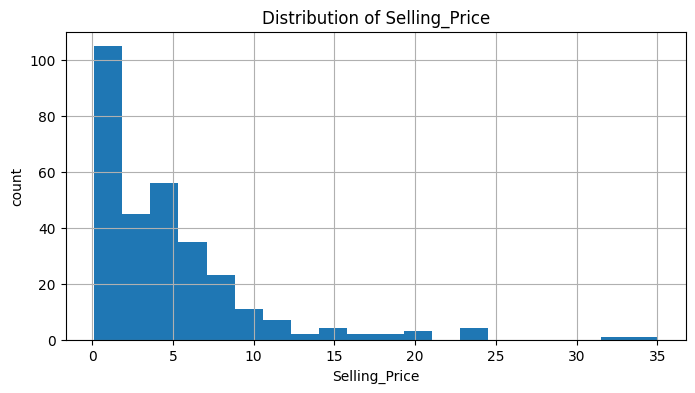

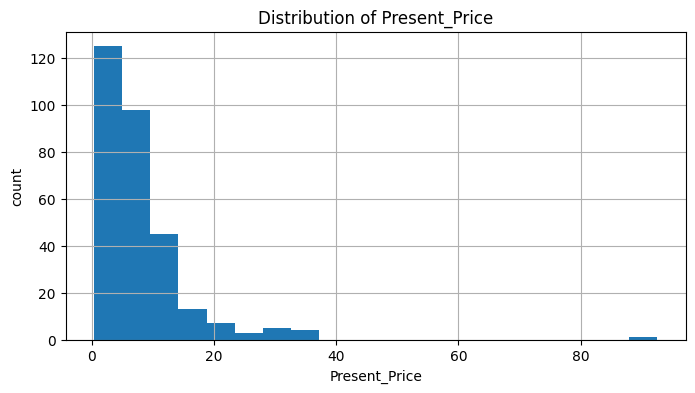

In [77]:
plt.figure(figsize=(8, 4))
df['Selling_Price'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('Selling_Price')
plt.title('Distribution of Selling_Price')

plt.figure(figsize=(8, 4))
df['Present_Price'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('Present_Price')
plt.title('Distribution of Present_Price')

plt.show()

Разбиваем данные на Train и Test (70/30) и проверяем корректность разбиения по долям.

In [118]:
df = df[df['Fuel_Type'] != 'CNG']

x = df.drop(columns=['Selling_Price'])
y = df['Selling_Price']

x_train_orig, x_test_orig, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=100)
x_train_orig.shape, x_test_orig.shape

((209, 8), (90, 8))

Попробуем преобразовать данные. Хочу попробовать, именно, с помощью PipeLine.

In [133]:
class DataPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.Year_max = None
        self.Year_min = None


    def fit(self, df, y=None):
        """Сохранение статистик"""

        # Расчет медиан
        self.Year_max = 2017
        self.Year_min = 2007

        return self

    def transform(self, df):
        """Трансформация данных"""

        df.loc[df['Year'] > self.Year_max, 'Year'] = self.Year_max
        df.loc[df['Year'] < self.Year_min, 'Year'] = self.Year_min

        if 'Owner' in df.columns:
            df.drop(columns='Owner', inplace=True)

        return df


Этого в лекции не было, но чтобы не повторяться с пердыдущим практичесским заданием попробую поработать с категориальными признаками (вместо того чтобы их исключить).
Информацию, как это делать искал в открытых источниках.

Нашел такой способ:

In [137]:
categorical_features = ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features) # drop='first' удаляет первую колонку для каждого признака, чтобы избежать "dummy trap"
    ],
    remainder='passthrough' # оставшиеся колонки будут переданы без изменений
)




In [141]:
pipe = make_pipeline(
    DataPipeline(),
    preprocessor,
    StandardScaler(),
)

In [121]:
pipe

Pipeline(steps=[('datapipeline',
                 <__main__.DataPipeline object at 0x7c3e2f233be0>),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Seller_Type',
                                                   'Transmission'])])),
                ('standardscaler', StandardScaler())])

In [142]:
x_train = pipe.fit_transform(x_train_orig)
x_test = pipe.transform(x_test_orig)




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Обучение модели:

In [123]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [124]:
y_train_preds = lr_model.predict(x_train)

Функция проверки качества модели:

In [127]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""

    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )

    plt.figure(figsize=(6, 6))

    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 35], [0, 35], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    if save == True:
        plt.savefig('report.png')
    plt.show()

Проверка качества модели на train данных (успешно):

R2:	0.957
RMSE:	1.141
MSE:	1.301


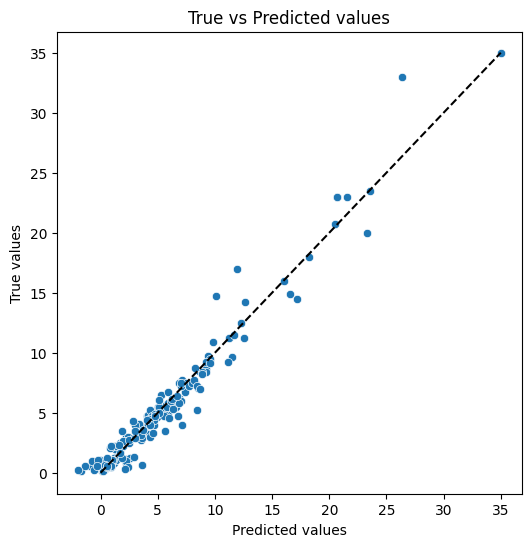

In [128]:
evaluate_preds(y_train, y_train_preds)

Проверка на тестовых данных (неудачно обучена модель):

R2:	0.09
RMSE:	3.726
MSE:	13.885


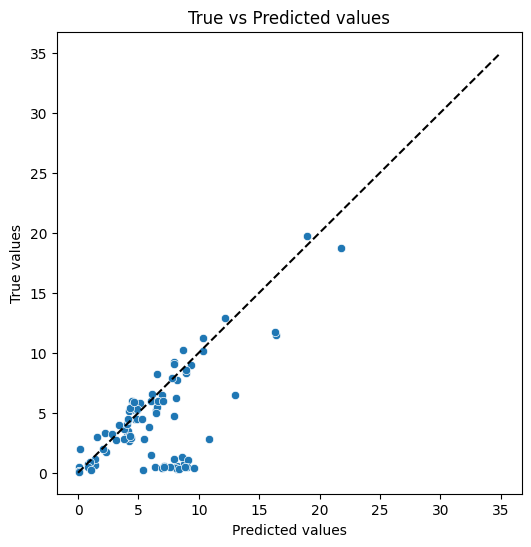

In [131]:
y_test_preds = lr_model.predict(x_test)
y_test_preds = np.clip(y_test_preds, a_min=0.1, a_max=35)
evaluate_preds(y_test, y_test_preds)

Попробуем доучить модель

In [146]:
pipe = make_pipeline(
    DataPipeline(),
    preprocessor,
    PolynomialFeatures(interaction_only=True),
    StandardScaler()
)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2:	0.998
RMSE:	0.246
MSE:	0.061


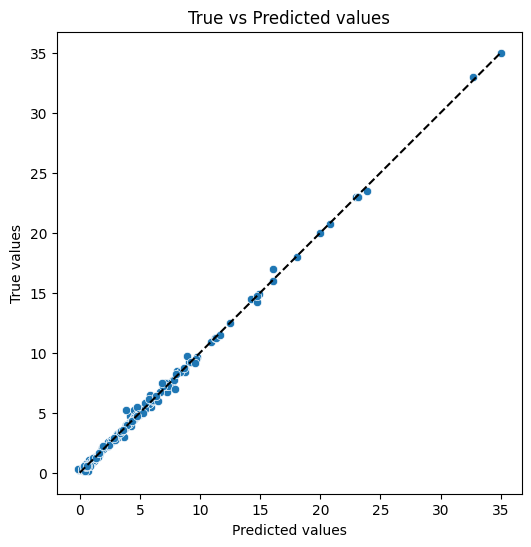

In [147]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)


x_train = pipe.fit_transform(x_train_orig)
x_test = pipe.transform(x_test_orig)
y_train_preds = lr_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

R2:	-18.118
RMSE:	17.076
MSE:	291.603


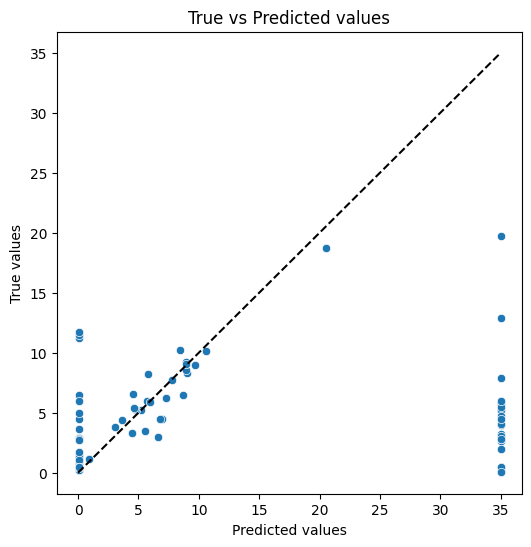

In [148]:
y_test_preds = lr_model.predict(x_test)
y_test_preds = np.clip(y_test_preds, a_min=0.1, a_max=35)
evaluate_preds(y_test, y_test_preds)

Дообучить модель не получилось.
Наверное, необходим какой-то другой подход для категориальных признаков.
